In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [2]:
# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = torch.device(device)
device

cuda


device(type='cuda')

In [3]:
smifile = "GDB17.50000000LLnoSR.smi"
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles"])
data = data.sample(n=1000000).reset_index(drop=True)

In [4]:
data.head()

,smiles
0,CC(C)N(C)CC1(CC(C(C)N)C(C)O1)C#C
1,CCNCC1=C(CC)N(C(N)=O)C(NCC)=C1
2,CC(C)CCOC1(C)OC(=O)C(CC=O)C1C
3,CCCC1=C2N(C)C3=C(NN=C3)N2C=C1
4,CC#CC1=NC2=C(C=O)N=NN2C(=O)C=C1


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

In [6]:
fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(data["smiles"][0]), 2, nBits=2048)

In [7]:
# fp to numpy array
arr = np.zeros((1,))
DataStructs.ConvertToNumpyArray(fp, arr)
arr

array([0., 1., 0., ..., 0., 0., 0.])

In [8]:
np.where(arr == 1)

(array([   1,   80,   81,   92,  283,  400,  564,  583,  656,  674,  679,
         722,  786,  881,  909,  915,  926,  955,  965,  974, 1019, 1057,
        1060, 1070, 1133, 1163, 1171, 1309, 1476, 1554, 1603, 1607, 1776,
        1778, 1915]),)

In [9]:
def get_fingerprint(smiles):
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=2048)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [10]:
sample = data["smiles"][:64]
fp_sample = [get_fingerprint(s) for s in sample]

In [11]:
print(fp_sample[0])

[0. 1. 0. ... 0. 0. 0.]


In [12]:
class SmilesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.smiles = data["smiles"]
    def __len__(self):
        return len(self.smiles)
    def __getitem__(self, idx):
        tensor = torch.from_numpy(get_fingerprint(self.smiles[idx])).float()
        return tensor

In [13]:
dataset = SmilesDataset(data)
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

In [14]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [15]:
for batch in train_loader:
    print(batch.shape)
    break

torch.Size([64, 2048])


In [16]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, latent_size)
        self.leaky_relu = nn.LeakyReLU()
        self.Dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.Dropout(self.leaky_relu(self.fc1(x)))
        x = self.Dropout(self.leaky_relu(self.fc2(x)))
        x = self.Dropout(self.leaky_relu(self.fc3(x)))
        x = self.leaky_relu(self.fc4(x))
        return x
class Decoder(nn.Module):
    def __init__(self, latent_size, output_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, output_size)
        self.leaky_relu = nn.LeakyReLU()
        self.Dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x, with_sigmoid=True):
        x = self.Dropout(self.leaky_relu(self.fc1(x)))
        x = self.Dropout(self.leaky_relu(self.fc2(x)))
        x = self.Dropout(self.leaky_relu(self.fc3(x)))
        if with_sigmoid:
            x = self.sigmoid(self.fc4(x))
        else:
            x = self.fc4(x)
        return x

In [17]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, dropout=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size, latent_size, dropout)
        self.decoder = Decoder(latent_size, input_size, dropout)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
model = Autoencoder(2048, 256, dropout=0.5).to(device)
history = {
    "train_loss": [],
    "valid_loss": []
}

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
model_name = "fp_autoencoder_drop_50%_2048_256.pt"

In [20]:
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
    print("Model loaded")
else:
    print("Model not found")

Model loaded


In [25]:
from datetime import datetime

epochs = 8
if len(history['valid_loss']) > 0:
    min_val_loss = min(history['valid_loss'])
else:
    min_val_loss = np.inf
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch.size(0)
    train_loss = train_loss/len(train_loader)
    history["train_loss"].append(train_loss)
    model.eval()
    for batch in valid_loader:
        batch = batch.to(device)
        output = model(batch)
        loss = criterion(output, batch)
        valid_loss += loss.item()*batch.size(0)
    valid_loss = valid_loss/len(valid_loader)
    if valid_loss < min_val_loss:
        torch.save(model.state_dict(), model_name)
        print("Model saved")
        min_val_loss = valid_loss
    history["valid_loss"].append(valid_loss)
    time = datetime.now().strftime(format="%H:%M:%S")
    print(f"Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}, Current time: {time}")

KeyboardInterrupt: 

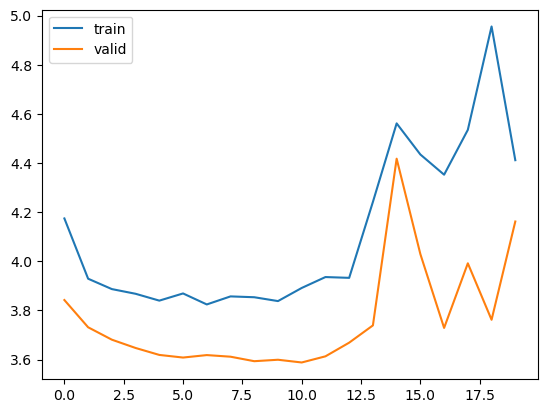

In [37]:
plt.plot(history["train_loss"], label="train")
plt.plot(history["valid_loss"], label="valid")
plt.legend()
plt.show()

In [21]:
diffs = []
total = 0
def compare_fps(fp1, fp2):
    # check which percent of ones from fp1 are in fp2
    fp1 = fp1.astype(int)
    fp2 = fp2.astype(int)
    fp1_idx = np.where(fp1 == 1)[0]
    fp2_idx = np.where(fp2 == 1)[0]
    return len(np.intersect1d(fp1_idx, fp2_idx))/len(fp1_idx)
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = model(batch)
        output = output > 0.5
        total += len(batch)
        for i in range(len(output)):
            batch_int = batch[i].cpu().detach().numpy().astype(int)
            output_int = output[i].cpu().detach().numpy().astype(int)
            out_idx = np.where(output_int == 1)[0]
            batch_idx = np.where(batch_int == 1)[0]
            # check how many elements from batch are in output
            diff = len(np.intersect1d(batch_idx, out_idx))
            # print(f'Batch: {batch_idx}')
            # print(f'Output: {out_idx}')
            # print(f'Diff: {diff / len(batch_idx)}')
            diffs.append(diff / len(batch_idx))

In [22]:
print(f"Accuracy: {np.mean(diffs):.5f}")

Accuracy: 0.28430


In [26]:
def get_models(model_name):
    model = Autoencoder(2048, 256).to(device)
    model.load_state_dict(torch.load(model_name))
    return model.encoder, model.decoder

In [27]:
encoder, decoder = get_models(model_name)
encoder.eval()
decoder.eval()

Decoder(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=2048, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (Dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

In [28]:
mdma = 'CC(NC)CC1=CC=C(OCO2)C2=C1'
mdma = get_fingerprint(mdma)
mdma = torch.from_numpy(mdma).float().to(device)
mdma = mdma.unsqueeze(0)

In [29]:
encoded = encoder(mdma)
encoded_bits = encoded.cpu().detach().numpy()
encoded

tensor([[-0.5952, -0.1309, -0.5005, -0.0697, -0.1355, -0.6427, -0.0920, -0.1059,
         -0.0947, -0.1167, -0.3070, -0.2942, -0.4593, -0.1075, -0.1034, -0.4011,
         -0.1717, -0.1255, -0.1127, -0.0528, -0.1856, -0.1663, -0.0816, -0.1151,
         -0.1161, -0.1671, -0.1317, -0.1052, -0.4438, -0.1118, -0.1665, -0.1201,
         -0.1352, -0.1541, -0.2288, -0.1405, -0.1038, -0.1797, -0.1904, -0.1384,
         -0.1338, -0.1679, -0.1036, -0.1713, -0.0991, -0.1643, -0.1266, -0.2364,
         -0.1607, -0.1119, -0.4200, -0.0918, -0.1565, -0.1296, -0.1053, -0.1582,
         -0.1163, -0.1357, -0.1774, -0.1009, -0.4973, -0.1367, -0.4442, -0.1004,
         -0.3133, -0.1415, -0.1498, -0.1533, -0.1304, -0.1671, -0.1571, -0.1124,
         -0.2626, -0.1705, -0.1758, -0.1347, -0.2705, -0.1684, -0.1328, -0.1435,
         -0.1689, -0.1182, -0.1175, -0.1586, -0.1956, -0.1394, -0.1389, -0.2714,
         -0.4270, -0.1173, -0.2148,  2.9857, -0.4860, -0.1223, -0.3053, -1.0399,
         -0.1230, -0.1563, -

In [33]:
decoded = decoder(encoded)
decoded = decoded.cpu().detach().numpy()
decoded = decoded > 0.5
decoded = decoded.astype(int)
print(np.where(decoded == 1)[1])

[   1   80  283  378  656  807 1057 1233 1380 1750 1873]


In [34]:
np.where(get_fingerprint('CC(NC)CC1=CC=C(OCO2)C2=C1') == 1)[0]

array([   1,   79,   80,  177,  283,  310,  441,  656,  738,  875,  926,
       1035, 1057, 1152, 1349, 1380, 1430, 1514, 1647, 1728, 1750, 1754,
       1800, 1863, 1873, 1905, 1907, 1990, 2018, 2031])

In [35]:
import pubchempy as pcp
# get all amino acids
names = ['Alanine', 'Arginine', 'Asparagine', 'Aspartic acid', 'Cysteine', 'Glutamic acid', 'Glutamine', 'Glycine', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Proline', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine']
aa_smiles = []
for name in names:
    aa = pcp.get_compounds(name, 'name')
    aa_smiles.append(aa[0].canonical_smiles)

In [36]:
aa_fps = [get_fingerprint(smile) for smile in aa_smiles]

In [37]:
encoded = encoder(torch.from_numpy(np.array(aa_fps)).float().to(device))

In [38]:
encoded = encoded.cpu().detach().numpy()

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(encoded)

PCA(n_components=2)

In [40]:
vec_pca = pca.transform(encoded)

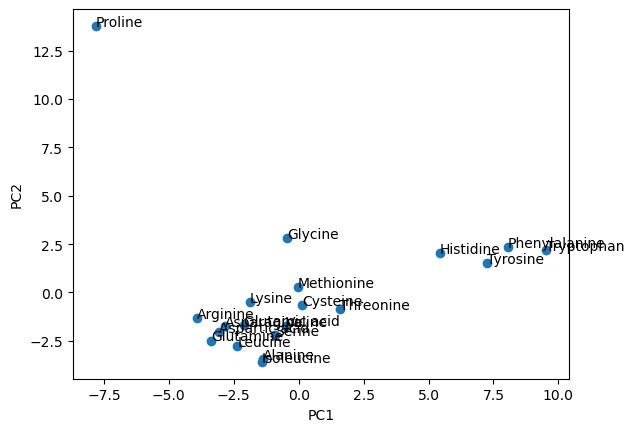

In [41]:
plt.scatter(vec_pca[:,0], vec_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
for i, txt in enumerate(names):
    plt.annotate(txt, (vec_pca[i,0], vec_pca[i,1]))

In [42]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=5)

In [43]:
tsne_componets = tsne.fit_transform(encoded)

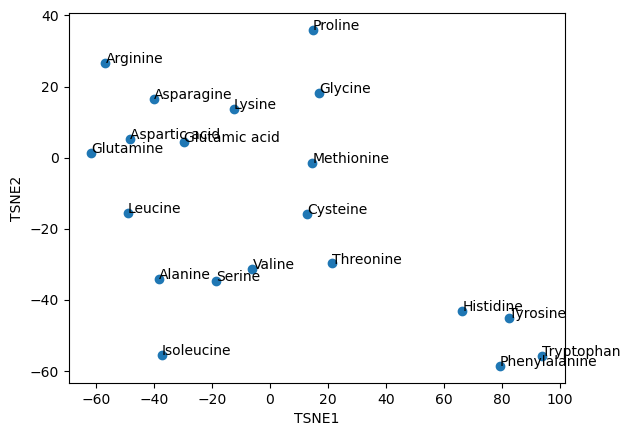

In [44]:
plt.scatter(tsne_componets[:,0], tsne_componets[:,1])
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
for i, txt in enumerate(names):
    plt.annotate(txt, (tsne_componets[i,0], tsne_componets[i,1]))

In [45]:
aa_map = {name:smile for name, smile in zip(names, aa_smiles)}

In [46]:
aa_map['Leucine']

'CC(C)CC(C(=O)O)N'

In [47]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
def tanimoto_similarity(smiles1, smiles2):
    '''
    Returns the Tanimoto similarity between two SMILES strings
    '''
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    return DataStructs.FingerprintSimilarity(fp1, fp2)

In [48]:
tanimoto_similarity(aa_map['Leucine'], aa_map['Isoleucine'])

0.4230769230769231

In [49]:
encoded_leucine = encoder(torch.from_numpy(np.array([get_fingerprint(aa_map['Leucine'])])).float().to(device))
encoded_leucine = encoded_leucine.cpu().detach().numpy()[0]
encoded_isoleucine = encoder(torch.from_numpy(np.array([get_fingerprint(aa_map['Isoleucine'])])).float().to(device))
encoded_isoleucine = encoded_isoleucine.cpu().detach().numpy()[0]

In [50]:
from scipy.spatial.distance import cosine, euclidean

In [51]:
print(f'Tanimoto distance: {tanimoto_similarity(aa_map["Leucine"], aa_map["Isoleucine"])}')
print(f'Cosine distance: {cosine(encoded_leucine, encoded_isoleucine)}')
print(f'Euclidean distance: {euclidean(encoded_leucine, encoded_isoleucine)}')

Tanimoto distance: 0.4230769230769231
Cosine distance: 0.12241095304489136
Euclidean distance: 6.468214988708496


In [52]:
results = {'Name':[], 'Tanimoto':[], 'Cosine':[], 'Euclidean':[]}
for name, smile in aa_map.items():
    encoded = encoder(torch.from_numpy(np.array([get_fingerprint(smile)])).float().to(device))
    encoded = encoded.cpu().detach().numpy()[0]
    results['Name'].append(name)
    results['Tanimoto'].append(tanimoto_similarity(aa_map['Leucine'], smile))
    results['Cosine'].append(1 - cosine(encoded_leucine, encoded))
    results['Euclidean'].append(euclidean(encoded_leucine, encoded))
df = pd.DataFrame(results).sort_values(by='Tanimoto', ascending=False)

In [53]:
df

,Name,Tanimoto,Cosine,Euclidean
10,Leucine,1.000000,1.000000,0.000000
3,Aspartic acid,0.545455,0.988446,1.856094
2,Asparagine,0.521739,0.985411,2.180902
15,Serine,0.500000,0.992096,2.234889
0,Alanine,0.500000,0.980404,2.552181
4,Cysteine,0.478261,0.992234,4.702408
12,Methionine,0.444444,0.993850,5.847207
5,Glutamic acid,0.440000,0.995295,1.983678
19,Valine,0.434783,0.985282,3.057423
6,Glutamine,0.423077,0.990206,1.784383


In [54]:
no_target = df[df['Name'] != 'Leucine']
print(f'Most similar in Tanimoto: {no_target.sort_values(by="Tanimoto", ascending=False).iloc[0,0]}')
print(f'Most similar in Cosine: {no_target.sort_values(by="Cosine", ascending=False).iloc[0,0]}')
print(f'Most similar in Euclidean: {no_target.sort_values(by="Euclidean", ascending=True).iloc[0,0]}')

Most similar in Tanimoto: Aspartic acid
Most similar in Cosine: Glutamic acid
Most similar in Euclidean: Glutamine


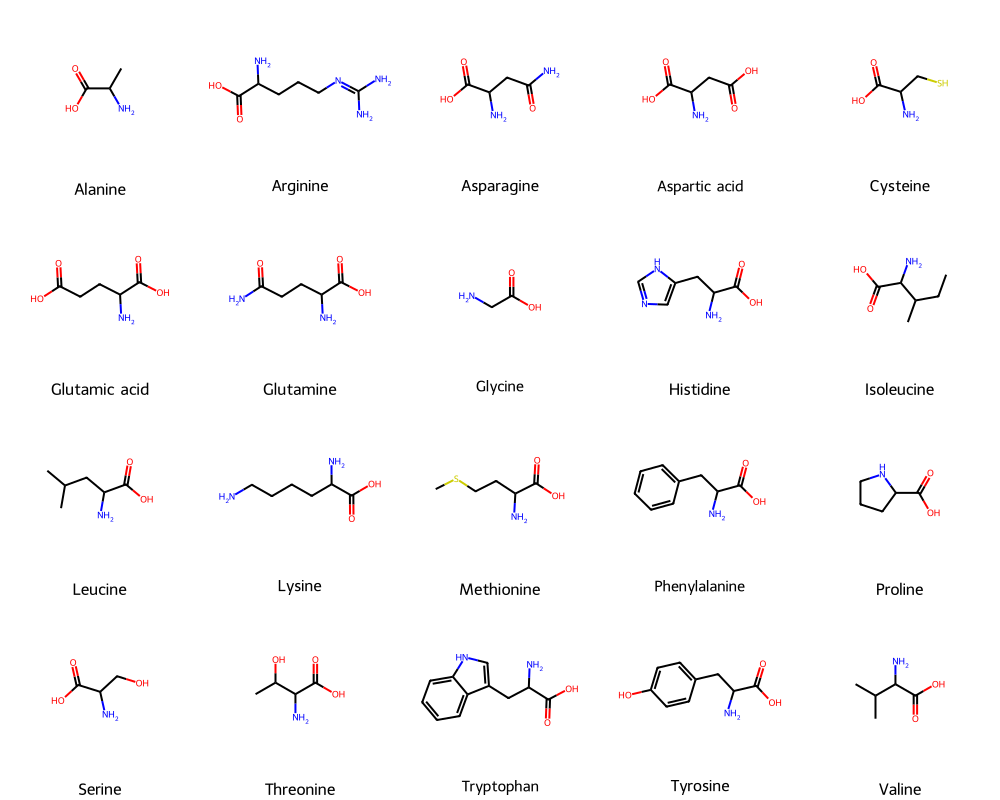

In [55]:
from rdkit.Chem import Draw
# draw all amino acids
mols = [Chem.MolFromSmiles(smile) for smile in aa_smiles]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=names)

In [56]:
# get substructure matches
from rdkit.Chem import rdFMCS
leucine = Chem.MolFromSmiles(aa_map['Leucine'])
glu = Chem.MolFromSmiles(aa_map['Glutamic acid'])
aspartic_acid = Chem.MolFromSmiles(aa_map['Aspartic acid'])
mcs = rdFMCS.FindMCS([leucine, glu, aspartic_acid], ringMatchesRingOnly=True, completeRingsOnly=True)
mcs = Chem.MolFromSmarts(mcs.smartsString)

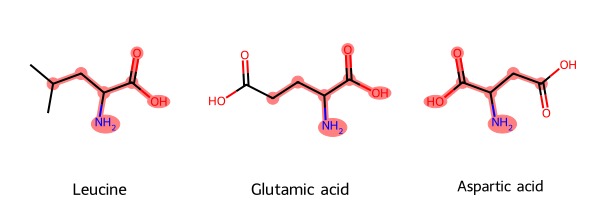

In [57]:
# draw substructure matches
Draw.MolsToGridImage([leucine, glu, aspartic_acid], molsPerRow=3, subImgSize=(200,200), highlightAtomLists=[leucine.GetSubstructMatch(mcs), glu.GetSubstructMatch(mcs), aspartic_acid.GetSubstructMatch(mcs)], legends=['Leucine', 'Glutamic acid', 'Aspartic acid'])